In [2]:
import pandas as pd
import numpy as np
import os
import glob
import calendar
import xlrd
from openpyxl import load_workbook

In [67]:
#read all files in folder 'Data/Monthly_2017-2023' in,
#extract 'Nameplate Capacity (MW)' of operating and standby capacity for coal, oil, gas, RES and others
#and save sums SORTED BY LOCALITIES in DataFrame

def extract_nameplate_capacity_LOCALITIES():
    path = "Data/Monthly_2017-2023"
    files = glob.glob(os.path.join(path, "*.xlsx"))
    #DataFrame which will contain sums of generating capacities
    df_gen = pd.DataFrame(columns=['Year','Month',
                                   'Capacity Gas (LI)','Capacity Coal (LI)','Capacity Oil (LI)','Capacity Renewables (LI)','Capacity Others (LI)',
                                   'Capacity Gas (NYC)','Capacity Coal (NYC)','Capacity Oil (NYC)','Capacity Renewables (NYC)','Capacity Others (NYC)',
                                   'Capacity Gas (GJ)','Capacity Coal (GJ)','Capacity Oil (GJ)','Capacity Renewables (GJ)','Capacity Others (GJ)',
                                   'Capacity Gas (NYCA)','Capacity Coal (NYCA)','Capacity Oil (NYCA)','Capacity Renewables (NYCA)','Capacity Others (NYCA)'
                                  ])
    counter = 0
    list_counties = pd.read_csv(path + "/New_York_Counties.csv", sep=";")
    list_counties.drop(columns=['Abbreviation','Zone'], inplace=True)
    dict_counties = {list_counties.iloc[i][0]: list_counties.iloc[i][1] for i in list_counties.T}

    for f in files:
        counter += 1

        #read files (f = 'Data\\Monthly_2017-2023\\january_generator2022.xlsx')
        #get month and year
        month = f.split("\\")[-1].split("_")[0]
        month = month.capitalize()
        year = f.split(".")[0][-4:]
        if int(year) > 2020:
            rows_to_skip = 2
        else:
            rows_to_skip = 1
        #montly generator data
        gen = pd.read_excel(f, sheet_name='Operating', skiprows=rows_to_skip)

        print(f)

        #delete all linebreaks and empty spaces in column names
        gen.columns = [x.replace("\n", "") for x in gen.columns.to_list()]
        gen.columns = [x.replace(" ", "") for x in gen.columns.to_list()]

        #ISO = New York
        #only operating capacity or in standby
        NY_gen = gen[gen['BalancingAuthorityCode']=='NYIS']
        NY_gen = NY_gen[(NY_gen['Status']=='(OP) Operating') | (NY_gen['Status']=='(SB) Standby/Backup: available for service but not normally used')]
        #map localities to counties
        NY_gen['Locality'] = NY_gen['County'].map(dict_counties)

        #sum capacity up by resource type
        #for each LOCALITY separately
        NY_gen_grouped = NY_gen.groupby(['Locality','EnergySourceCode'])
        #gas: 'BFG','NG','OG'
        gas_flag = False
        for (name, group) in NY_gen_grouped:
            if name[1] in ['BFG','NG','OG']:
                NY_gen_gas = pd.concat([group for (name, group) in NY_gen_grouped if name[1] in ['BFG','NG','OG']])
                NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].replace(" ",0)
                NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].astype(float)
                NY_gen_gas_sum = NY_gen_gas.groupby('Locality')['NameplateCapacity(MW)'].sum()
        if len(NY_gen_gas_sum) < 4:
            for loc in ['GJ','LI','NYC','NYCA']:
                if loc not in NY_gen_gas_sum.index:
                    NY_gen_gas_sum[loc] = 0

        #coal: 'ANT','BIT','LIG','SGC','SUB','WC','RC'
        coal_flag = False
        for (name, group) in NY_gen_grouped:
            if name[1] in ['ANT','BIT','LIG','SGC','SUB','WC','RC']:
                NY_gen_coal = pd.concat([group for (name, group) in NY_gen_grouped if name[1] in ['ANT','BIT','LIG','SGC','SUB','WC','RC']])
                NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].replace(" ",0)
                NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].astype(float)
                NY_gen_coal_sum = NY_gen_coal.groupby('Locality')['NameplateCapacity(MW)'].sum()
        if len(NY_gen_coal_sum) < 4:
            for loc in ['GJ','LI','NYC','NYCA']:
                if loc not in NY_gen_coal_sum.index:
                    NY_gen_coal_sum[loc] = 0

        #petroleum products: 'DFO','JF','KER','PC','PG','RFO','SGP','WO'
        oil_flag = False
        for (name, group) in NY_gen_grouped:
            if name[1] in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']:
                NY_gen_oil = pd.concat([group for (name, group) in NY_gen_grouped if name[1] in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']])
                NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].replace(" ",0)
                NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].astype(float)
                NY_gen_oil_sum = NY_gen_oil.groupby('Locality')['NameplateCapacity(MW)'].sum()
        if len(NY_gen_oil_sum) < 4:
            for loc in ['GJ','LI','NYC','NYCA']:
                if loc not in NY_gen_oil_sum.index:
                    NY_gen_oil_sum[loc] = 0

        #renewables: 'AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT'
        res_flag = False
        for (name, group) in NY_gen_grouped:
            if name[1] in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']:
                NY_gen_res = pd.concat([group for (name, group) in NY_gen_grouped if name[1] in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']])
                NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].replace(" ",0)
                NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].astype(float)
                NY_gen_res_sum = NY_gen_res.groupby('Locality')['NameplateCapacity(MW)'].sum()
        if len(NY_gen_res_sum) < 4:
            for loc in ['GJ','LI','NYC','NYCA']:
                if loc not in NY_gen_res_sum.index:
                    NY_gen_res_sum[loc] = 0

        #other products: 'NUC','PUR','WH','TDF','MWH','OTH'
        oth_flag = False
        for (name, group) in NY_gen_grouped:
            if name[1] in ['NUC','PUR','WH','TDF','MWH','OTH']:
                NY_gen_oth = pd.concat([group for (name, group) in NY_gen_grouped if name[1] in ['NUC','PUR','WH','TDF','MWH','OTH']])
                NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].replace(" ",0)
                NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].astype(float)
                NY_gen_oth_sum = NY_gen_oth.groupby('Locality')['NameplateCapacity(MW)'].sum()
        if len(NY_gen_oth_sum) < 4:
            for loc in ['GJ','LI','NYC','NYCA']:
                if loc not in NY_gen_oth_sum.index:
                    NY_gen_oth_sum[loc] = 0

        #save generating capacity data in DataFrame
        new_row = pd.DataFrame(data={'Year':year, 'Month':month,
                                     'Capacity Gas (LI)':NY_gen_gas_sum[NY_gen_gas_sum.index=="LI"][0], 
                                     'Capacity Coal (LI)':NY_gen_coal_sum[NY_gen_coal_sum.index=="LI"][0],
                                     'Capacity Oil (LI)':NY_gen_oil_sum[NY_gen_oil_sum.index=="LI"][0], 
                                     'Capacity Renewables (LI)':NY_gen_res_sum[NY_gen_res_sum.index=="LI"][0],
                                     'Capacity Others (LI)':NY_gen_oth_sum[NY_gen_oth_sum.index=="LI"][0],
                                     'Capacity Gas (NYC)':NY_gen_gas_sum[NY_gen_gas_sum.index=="NYC"][0], 
                                     'Capacity Coal (NYC)':NY_gen_coal_sum[NY_gen_coal_sum.index=="NYC"][0],
                                     'Capacity Oil (NYC)':NY_gen_oil_sum[NY_gen_oil_sum.index=="NYC"][0], 
                                     'Capacity Renewables (NYC)':NY_gen_res_sum[NY_gen_res_sum.index=="NYC"][0],
                                     'Capacity Others (NYC)':NY_gen_oth_sum[NY_gen_oth_sum.index=="NYC"][0],
                                     'Capacity Gas (GJ)':NY_gen_gas_sum[NY_gen_gas_sum.index=="GJ"][0], 
                                     'Capacity Coal (GJ)':NY_gen_coal_sum[NY_gen_coal_sum.index=="GJ"][0],
                                     'Capacity Oil (GJ)':NY_gen_oil_sum[NY_gen_oil_sum.index=="GJ"][0], 
                                     'Capacity Renewables (GJ)':NY_gen_res_sum[NY_gen_res_sum.index=="GJ"][0],
                                     'Capacity Others (GJ)':NY_gen_oth_sum[NY_gen_oth_sum.index=="GJ"][0],
                                     'Capacity Gas (NYCA)':NY_gen_gas_sum[NY_gen_gas_sum.index=="NYCA"][0], 
                                     'Capacity Coal (NYCA)':NY_gen_coal_sum[NY_gen_coal_sum.index=="NYCA"][0],
                                     'Capacity Oil (NYCA)':NY_gen_oil_sum[NY_gen_oil_sum.index=="NYCA"][0], 
                                     'Capacity Renewables (NYCA)':NY_gen_res_sum[NY_gen_res_sum.index=="NYCA"][0],
                                     'Capacity Others (NYCA)':NY_gen_oth_sum[NY_gen_oth_sum.index=="NYCA"][0]}, 
                                index=[counter])
        df_gen = pd.concat([df_gen.reset_index(drop=True), new_row.reset_index(drop=True)])
        #save every 10th run as .csv file (still unsorted version, perliminary)
        if counter%10 == 0:
            df_gen.to_csv('Montly_Generating_Capacity_EIA_allSources_LOCALITIES.csv', index=False)  


    #sort by year and month
    months_in_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    df_gen['Month'] = pd.Categorical(df_gen['Month'], categories=months_in_order, ordered=True)
    df_gen.sort_values(by=['Year','Month'], inplace=True)
    #convert year and month to datetime format
    d = {month: index for index, month in enumerate(calendar.month_name) if month}
    df_gen['Month'] = df_gen['Month'].map(d)
    df_gen['Date'] = pd.to_datetime(dict(year=df_gen['Year'], month=df_gen['Month'], day=1))
    df_gen.drop(['Year','Month'], axis='columns', inplace=True)
    #move date column to the left
    df_gen.insert(0, 'Date', df_gen.pop('Date'))

    #save as .csv file (sorted, complete data)
    df_gen.to_csv('Monthly_Generating_Capacity_EIA_allSources_LOCALITIES.csv', index=False) 

    return df_gen


In [68]:
df_gen_operating_LOCALITIES = extract_nameplate_capacity_LOCALITIES()

Data/Monthly_2017-2023\april_generator2017.xlsx
Data/Monthly_2017-2023\april_generator2018.xlsx
Data/Monthly_2017-2023\april_generator2019.xlsx
Data/Monthly_2017-2023\april_generator2020.xlsx
Data/Monthly_2017-2023\april_generator2021.xlsx
Data/Monthly_2017-2023\april_generator2022.xlsx
Data/Monthly_2017-2023\august_generator2017.xlsx
Data/Monthly_2017-2023\august_generator2018.xlsx
Data/Monthly_2017-2023\august_generator2019.xlsx
Data/Monthly_2017-2023\august_generator2020.xlsx
Data/Monthly_2017-2023\august_generator2021.xlsx
Data/Monthly_2017-2023\august_generator2022.xlsx
Data/Monthly_2017-2023\december_generator2017.xlsx
Data/Monthly_2017-2023\december_generator2018.xlsx
Data/Monthly_2017-2023\december_generator2019.xlsx
Data/Monthly_2017-2023\december_generator2020.xlsx
Data/Monthly_2017-2023\december_generator2021.xlsx
Data/Monthly_2017-2023\december_generator2022.xlsx
Data/Monthly_2017-2023\february_generator2017.xlsx
Data/Monthly_2017-2023\february_generator2018.xlsx
Data/Month

In [29]:
#read all files in folder 'Data/Monthly_2017-2023' in,
#extract 'Nameplate Capacity (MW)' of operating and standby capacity for coal, oil, gas, RES and others
#and save sums in DataFrame

def extract_nameplate_capacity():
    path = "Data/Monthly_2017-2023"
    files = glob.glob(os.path.join(path, "*.xlsx"))
    #DataFrame which will contain sums of generating capacities
    df_gen = pd.DataFrame(columns=['Year','Month','Capacity Gas (MW)','Capacity Coal (MW)','Capacity Oil (MW)',
                                   'Capacity Renewables (MW)','Capacity Others (MW)'])
    counter = 0

    for f in files:
        counter += 1

        #read files (f = 'Data\\Monthly_2017-2023\\january_generator2022.xlsx')
        #get month and year
        month = f.split("\\")[-1].split("_")[0]
        month = month.capitalize()
        year = f.split(".")[0][-4:]
        if int(year) > 2020:
            rows_to_skip = 2
        else:
            rows_to_skip = 1
        #montly generator data
        gen = pd.read_excel(f, sheet_name='Operating', skiprows=rows_to_skip)

        print(f)

        #delete all linebreaks and empty spaces in column names
        gen.columns = [x.replace("\n", "") for x in gen.columns.to_list()]
        gen.columns = [x.replace(" ", "") for x in gen.columns.to_list()]

        #ISO = New York
        #only operating capacity or in standby
        NY_gen = gen[gen['BalancingAuthorityCode']=='NYIS']
        NY_gen = NY_gen[(NY_gen['Status']=='(OP) Operating') | (NY_gen['Status']=='(SB) Standby/Backup: available for service but not normally used')]
        #sum capacity up by resource type
        NY_gen_grouped = NY_gen.groupby('EnergySourceCode')
        #gas: 'BFG','NG','OG'
        gas_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['BFG','NG','OG']:
                gas_flag = True
        if gas_flag == True:
            NY_gen_gas = pd.concat([group for (name, group) in NY_gen_grouped if name in ['BFG','NG','OG']])
            NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].astype(float)
            NY_gen_gas_sum = NY_gen_gas['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_gas_sum = 0
        #coal: 'ANT','BIT','LIG','SGC','SUB','WC','RC'
        coal_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']:
                coal_flag = True
        if coal_flag == True:
            NY_gen_coal = pd.concat([group for (name, group) in NY_gen_grouped if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']])
            NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].astype(float)
            NY_gen_coal_sum = NY_gen_coal['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_coal_sum = 0
        #petroleum products: 'DFO','JF','KER','PC','PG','RFO','SGP','WO'
        oil_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']:
                oil_flag = True
        if oil_flag == True:
            NY_gen_oil = pd.concat([group for (name, group) in NY_gen_grouped if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']])
            NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].astype(float)
            NY_gen_oil_sum = NY_gen_oil['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_oil_sum = 0
        #renewables: 'AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT'
        res_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']:
                res_flag = True
        if res_flag == True:
            NY_gen_res = pd.concat([group for (name, group) in NY_gen_grouped if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']])
            NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].astype(float)
            NY_gen_res_sum = NY_gen_res['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_res_sum = 0
        #other products: 'NUC','PUR','WH','TDF','MWH','OTH'
        oth_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['NUC','PUR','WH','TDF','MWH','OTH']:
                oth_flag = True
        if oth_flag == True:
            NY_gen_oth = pd.concat([group for (name, group) in NY_gen_grouped if name in ['NUC','PUR','WH','TDF','MWH','OTH']])
            NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].astype(float)
            NY_gen_oth_sum = NY_gen_oth['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_oth_sum = 0

        #save generating capacity data in DataFrame
        new_row = pd.DataFrame(data={'Year':year, 'Month':month, 'Capacity Gas (MW)':NY_gen_gas_sum, 
                                     'Capacity Coal (MW)':NY_gen_coal_sum, 'Capacity Oil (MW)':NY_gen_oil_sum, 
                                     'Capacity Renewables (MW)':NY_gen_res_sum, 'Capacity Others (MW)':NY_gen_oth_sum}, 
                                index=[counter])
        df_gen = pd.concat([df_gen.reset_index(drop=True), new_row.reset_index(drop=True)])
        #save every 10th run as .csv file (still unsorted version, perliminary)
        if counter%10 == 0:
            df_gen.to_csv('Montly_Generating_Capacity_EIA_allSources.csv', index=False)  


    #sort by year and month
    months_in_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    df_gen['Month'] = pd.Categorical(df_gen['Month'], categories=months_in_order, ordered=True)
    df_gen.sort_values(by=['Year','Month'], inplace=True)
    #convert year and month to datetime format
    d = {month: index for index, month in enumerate(calendar.month_name) if month}
    df_gen['Month'] = df_gen['Month'].map(d)
    df_gen['Date'] = pd.to_datetime(dict(year=df_gen['Year'], month=df_gen['Month'], day=1))
    df_gen.drop(['Year','Month'], axis='columns', inplace=True)
    #move date column to the left
    df_gen.insert(0, 'Date', df_gen.pop('Date'))

    #save as .csv file (sorted, complete data)
    df_gen.to_csv('Monthly_Generating_Capacity_EIA_allSources.csv', index=False) 

    return df_gen

In [30]:
df_gen_operating = extract_nameplate_capacity()

Data/Monthly_2017-2023\april_generator2017.xlsx
Data/Monthly_2017-2023\april_generator2018.xlsx
Data/Monthly_2017-2023\april_generator2019.xlsx
Data/Monthly_2017-2023\april_generator2020.xlsx
Data/Monthly_2017-2023\april_generator2021.xlsx
Data/Monthly_2017-2023\april_generator2022.xlsx
Data/Monthly_2017-2023\august_generator2017.xlsx
Data/Monthly_2017-2023\august_generator2018.xlsx
Data/Monthly_2017-2023\august_generator2019.xlsx
Data/Monthly_2017-2023\august_generator2020.xlsx
Data/Monthly_2017-2023\august_generator2021.xlsx
Data/Monthly_2017-2023\august_generator2022.xlsx
Data/Monthly_2017-2023\december_generator2017.xlsx
Data/Monthly_2017-2023\december_generator2018.xlsx
Data/Monthly_2017-2023\december_generator2019.xlsx
Data/Monthly_2017-2023\december_generator2020.xlsx
Data/Monthly_2017-2023\december_generator2021.xlsx
Data/Monthly_2017-2023\december_generator2022.xlsx
Data/Monthly_2017-2023\february_generator2017.xlsx
Data/Monthly_2017-2023\february_generator2018.xlsx
Data/Month

In [32]:
#read all files in folder 'Data/Monthly_2017-2023' in,
#extract 'Nameplate Capacity (MW)' of planned capacity for coal, oil, gas, RES and others
#and save sums in DataFrame

def extract_planned_nameplate_capacity():
    path = "Data/Monthly_2017-2023"
    files = glob.glob(os.path.join(path, "*.xlsx"))
    #DataFrame which will contain sums of generating capacities
    df_gen = pd.DataFrame(columns=['Year','Month','Capacity Gas (MW)','Capacity Coal (MW)','Capacity Oil (MW)',
                                   'Capacity Renewables (MW)','Capacity Others (MW)'])
    counter = 0

    for f in files:
        counter += 1

        #read files (f = 'Data\\january_generator2022.xlsx')
        #get month and year
        month = f.split("\\")[-1].split("_")[0]
        month = month.capitalize()
        year = f.split(".")[0][-4:]
        if int(year) > 2020:
            rows_to_skip = 2
        else:
            rows_to_skip = 1
        #montly generator data
        gen = pd.read_excel(f, sheet_name='Planned', skiprows=rows_to_skip)

        print(f)
        
        #delete all linebreaks and empty spaces in column names
        gen.columns = [x.replace("\n", "") for x in gen.columns.to_list()]
        gen.columns = [x.replace(" ", "") for x in gen.columns.to_list()]

        #ISO = New York
        NY_gen = gen[gen['BalancingAuthorityCode']=='NYIS']
        #sum capacity up by resource type
        NY_gen_grouped = NY_gen.groupby('EnergySourceCode')
        #gas: 'BFG','NG','OG'
        gas_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['BFG','NG','OG']:
                gas_flag = True
        if gas_flag == True:
            NY_gen_gas = pd.concat([group for (name, group) in NY_gen_grouped if name in ['BFG','NG','OG']])
            NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_gas['NameplateCapacity(MW)'] = NY_gen_gas['NameplateCapacity(MW)'].astype(float)
            NY_gen_gas_sum = NY_gen_gas['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_gas_sum = 0
        #coal: 'ANT','BIT','LIG','SGC','SUB','WC','RC'
        coal_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']:
                coal_flag = True
        if coal_flag == True:
            NY_gen_coal = pd.concat([group for (name, group) in NY_gen_grouped if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']])
            NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_coal['NameplateCapacity(MW)'] = NY_gen_coal['NameplateCapacity(MW)'].astype(float)
            NY_gen_coal_sum = NY_gen_coal['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_coal_sum = 0
        #petroleum products: 'DFO','JF','KER','PC','PG','RFO','SGP','WO'
        oil_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']:
                oil_flag = True
        if oil_flag == True:
            NY_gen_oil = pd.concat([group for (name, group) in NY_gen_grouped if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']])
            NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_oil['NameplateCapacity(MW)'] = NY_gen_oil['NameplateCapacity(MW)'].astype(float)
            NY_gen_oil_sum = NY_gen_oil['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_oil_sum = 0
        #renewables: 'AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT'
        res_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']:
                res_flag = True
        if res_flag == True:
            NY_gen_res = pd.concat([group for (name, group) in NY_gen_grouped if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']])
            NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_res['NameplateCapacity(MW)'] = NY_gen_res['NameplateCapacity(MW)'].astype(float)
            NY_gen_res_sum = NY_gen_res['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_res_sum = 0
        #other products: 'NUC','PUR','WH','TDF','MWH','OTH'
        oth_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['NUC','PUR','WH','TDF','MWH','OTH']:
                oth_flag = True
        if oth_flag == True:
            NY_gen_oth = pd.concat([group for (name, group) in NY_gen_grouped if name in ['NUC','PUR','WH','TDF','MWH','OTH']])
            NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].replace(" ",0)
            NY_gen_oth['NameplateCapacity(MW)'] = NY_gen_oth['NameplateCapacity(MW)'].astype(float)
            NY_gen_oth_sum = NY_gen_oth['NameplateCapacity(MW)'].sum()
        else:
            NY_gen_oth_sum = 0

        #save generating capacity data in DataFrame
        new_row = pd.DataFrame(data={'Year':year, 'Month':month, 'Capacity Gas (MW)':NY_gen_gas_sum, 
                                     'Capacity Coal (MW)':NY_gen_coal_sum, 'Capacity Oil (MW)':NY_gen_oil_sum, 
                                     'Capacity Renewables (MW)':NY_gen_res_sum, 'Capacity Others (MW)':NY_gen_oth_sum}, 
                               index=[counter])
        df_gen = pd.concat([df_gen.reset_index(drop=True), new_row.reset_index(drop=True)])
        #save every 10th run as .csv file (still unsorted version, perliminary)
        if counter%10 == 0:
            df_gen.to_csv('Monthly_Generating_Capacity_EIA_Planned_allSources.csv', index=False)  


    #sort by year and month
    months_in_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    df_gen['Month'] = pd.Categorical(df_gen['Month'], categories=months_in_order, ordered=True)
    df_gen.sort_values(by=['Year','Month'], inplace=True)
    #convert year and month to datetime format
    d = {month: index for index, month in enumerate(calendar.month_name) if month}
    df_gen['Month'] = df_gen['Month'].map(d)
    df_gen['Date'] = pd.to_datetime(dict(year=df_gen['Year'], month=df_gen['Month'], day=1))
    df_gen.drop(['Year','Month'], axis='columns', inplace=True)
    #move date column to the left
    df_gen.insert(0, 'Date', df_gen.pop('Date'))

    #save as .csv file (sorted, complete data)
    df_gen.to_csv('Monthly_Generating_Capacity_EIA_Planned_allSources.csv', index=False) 

    return df_gen

In [33]:
df_gen_planned = extract_planned_nameplate_capacity()

Data/Monthly_2017-2023\april_generator2017.xlsx
Data/Monthly_2017-2023\april_generator2018.xlsx
Data/Monthly_2017-2023\april_generator2019.xlsx
Data/Monthly_2017-2023\april_generator2020.xlsx
Data/Monthly_2017-2023\april_generator2021.xlsx
Data/Monthly_2017-2023\april_generator2022.xlsx
Data/Monthly_2017-2023\august_generator2017.xlsx
Data/Monthly_2017-2023\august_generator2018.xlsx
Data/Monthly_2017-2023\august_generator2019.xlsx
Data/Monthly_2017-2023\august_generator2020.xlsx
Data/Monthly_2017-2023\august_generator2021.xlsx
Data/Monthly_2017-2023\august_generator2022.xlsx
Data/Monthly_2017-2023\december_generator2017.xlsx
Data/Monthly_2017-2023\december_generator2018.xlsx
Data/Monthly_2017-2023\december_generator2019.xlsx
Data/Monthly_2017-2023\december_generator2020.xlsx
Data/Monthly_2017-2023\december_generator2021.xlsx
Data/Monthly_2017-2023\december_generator2022.xlsx
Data/Monthly_2017-2023\february_generator2017.xlsx
Data/Monthly_2017-2023\february_generator2018.xlsx
Data/Month

In [34]:
#read all files in folder 'Data/Annual_2004-2016' in,
#extract 'Nameplate Capacity (MW)' of operating and standby capacity for coal, oil, gas, RES and others
#and save sums in DataFrame

def extract_nameplate_capacity_annual():
    path = "Data/Annual_2004-2016"
    files = glob.glob(os.path.join(path, "*.xls*"))
    #DataFrame which will contain sums of generating capacities
    df_gen = pd.DataFrame(columns=['Year','Capacity Gas (MW)','Capacity Coal (MW)','Capacity Oil (MW)',
                                   'Capacity Renewables (MW)','Capacity Others (MW)'])
    counter = 0

    for f in files:
        counter += 1

        #read files (f = 'Data\\Annual_2004-2016\\Generator_Y2004.xls' or f = 'Data\\Annual_2004-2016\\Generator_Y2016.xlsx')
        #get type and year
        file_type = f.split(".")[-1] #.xls or .xlsx
        year = f.split(".")[0][-4:]
        if file_type == "xls":
            rows_to_skip = 0
        else:
            rows_to_skip = 1

        #annual generator data
        gen = pd.read_excel(f, skiprows=rows_to_skip)

        #get right column names
        if file_type == "xls":
            state = 'STATE'
            energy_source_code = 'ENERGY_SOURCE_1'
            nameplate = 'NAMEPLATE'
        else:
            if 'State' in gen.columns:
                state = 'State'
                energy_source_code = 'EnergySource1'
                nameplate = 'NameplateCapacity(MW)'
            else:
                state = 'STATE'
                energy_source_code = 'ENERGY_SOURCE_1'
                nameplate = 'NAMEPLATE'

        print(f)

        #delete all linebreaks and empty spaces in column names
        gen.columns = [x.replace("\n", "") for x in gen.columns.to_list()]
        gen.columns = [x.replace(" ", "") for x in gen.columns.to_list()]

        #state = New York (approximately NYISO because ISO not given)
        NY_gen = gen[gen[state]=='NY']

        #sum capacity up by resource type
        NY_gen_grouped = NY_gen.groupby(energy_source_code)
        #gas: 'BFG','NG','OG'
        gas_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['BFG','NG','OG']:
                gas_flag = True
        if gas_flag == True:
            NY_gen_gas = pd.concat([group for (name, group) in NY_gen_grouped if name in ['BFG','NG','OG']])
            NY_gen_gas[nameplate] = NY_gen_gas[nameplate].replace(" ",0)
            NY_gen_gas[nameplate] = NY_gen_gas[nameplate].astype(float)
            NY_gen_gas_sum = NY_gen_gas[nameplate].sum()
        else:
            NY_gen_gas_sum = 0
        #coal: 'ANT','BIT','LIG','SGC','SUB','WC','RC'
        coal_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']:
                coal_flag = True
        if coal_flag == True:
            NY_gen_coal = pd.concat([group for (name, group) in NY_gen_grouped if name in ['ANT','BIT','LIG','SGC','SUB','WC','RC']])
            NY_gen_coal[nameplate] = NY_gen_coal[nameplate].replace(" ",0)
            NY_gen_coal[nameplate] = NY_gen_coal[nameplate].astype(float)
            NY_gen_coal_sum = NY_gen_coal[nameplate].sum()
        else:
            NY_gen_coal_sum = 0
        #petroleum products: 'DFO','JF','KER','PC','PG','RFO','SGP','WO'
        oil_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']:
                oil_flag = True
        if oil_flag == True:
            NY_gen_oil = pd.concat([group for (name, group) in NY_gen_grouped if name in ['DFO','JF','KER','PC','PG','RFO','SGP','WO']])
            NY_gen_oil[nameplate] = NY_gen_oil[nameplate].replace(" ",0)
            NY_gen_oil[nameplate] = NY_gen_oil[nameplate].astype(float)
            NY_gen_oil_sum = NY_gen_oil[nameplate].sum()
        else:
            NY_gen_oil_sum = 0
        #renewables: 'AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT'
        res_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']:
                res_flag = True
        if res_flag == True:
            NY_gen_res = pd.concat([group for (name, group) in NY_gen_grouped if name in ['AB','MSW','OBS','WDS','OBL','SLW','BLQ','WDL','LFG','OBG','SUN','WND','GEO','WAT']])
            NY_gen_res[nameplate] = NY_gen_res[nameplate].replace(" ",0)
            NY_gen_res[nameplate] = NY_gen_res[nameplate].astype(float)
            NY_gen_res_sum = NY_gen_res[nameplate].sum()
        else:
            NY_gen_res_sum = 0
        #other products: 'NUC','PUR','WH','TDF','MWH','OTH'
        oth_flag = False
        for (name, group) in NY_gen_grouped:
            if name in ['NUC','PUR','WH','TDF','MWH','OTH']:
                oth_flag = True
        if oth_flag == True:
            NY_gen_oth = pd.concat([group for (name, group) in NY_gen_grouped if name in ['NUC','PUR','WH','TDF','MWH','OTH']])
            NY_gen_oth[nameplate] = NY_gen_oth[nameplate].replace(" ",0)
            NY_gen_oth[nameplate] = NY_gen_oth[nameplate].astype(float)
            NY_gen_oth_sum = NY_gen_oth[nameplate].sum()
        else:
            NY_gen_oth_sum = 0

        #save generating capacity data in DataFrame
        new_row = pd.DataFrame(data={'Year':year, 'Capacity Gas (MW)':NY_gen_gas_sum, 
                                     'Capacity Coal (MW)':NY_gen_coal_sum, 'Capacity Oil (MW)':NY_gen_oil_sum, 
                                     'Capacity Renewables (MW)':NY_gen_res_sum, 'Capacity Others (MW)':NY_gen_oth_sum}, 
                                index=[counter])
        df_gen = pd.concat([df_gen.reset_index(drop=True), new_row.reset_index(drop=True)])
        #save every 10th run as .csv file (still unsorted version, perliminary)
        if counter%10 == 0:
            df_gen.to_csv('Annual_Generating_Capacity_EIA_allSources.csv', index=False)


    #sort by year
    df_gen.sort_values(by='Year', inplace=True)
    #convert year to datetime format
    df_gen['Date'] = pd.to_datetime(df_gen['Year'])
    df_gen.drop('Year', axis='columns', inplace=True)
    #move date column to the left
    df_gen.insert(0, 'Date', df_gen.pop('Date'))

    #save as .csv file (sorted, complete data)
    df_gen.to_csv('Annual_Generating_Capacity_EIA_allSources.csv', index=False) 

    return df_gen

In [35]:
df_gen_yearly = extract_nameplate_capacity_annual()

Data/Annual_2004-2016\Generator_Y2004.xls
Data/Annual_2004-2016\Generator_Y2005.xls
Data/Annual_2004-2016\Generator_Y2006.xls
Data/Annual_2004-2016\Generator_Y2007.xls
Data/Annual_2004-2016\Generator_Y2008.xls
Data/Annual_2004-2016\Generator_Y2009.xls
Data/Annual_2004-2016\Generator_Y2010.xls
Data/Annual_2004-2016\Generator_Y2011.xlsx
Data/Annual_2004-2016\Generator_Y2012.xlsx
Data/Annual_2004-2016\Generator_Y2013.xlsx
Data/Annual_2004-2016\Generator_Y2014.xlsx
Data/Annual_2004-2016\Generator_Y2015.xlsx
Data/Annual_2004-2016\Generator_Y2016.xlsx


In [4]:
#read all files in folder 'Data/ICAP_Monthly_Market_Report' in,
#extract 'UCAP Requirement' for all four zones
#and save for each month in DataFrame

def extract_UCAP_requirements():
    path = "Data/ICAP_Monthly_Market_Report"
    files = glob.glob(os.path.join(path, "*.xls*"))
    #DataFrame which will contain sums of generating capacities
    df_gen = pd.DataFrame(columns=['Year','Month','UCAP NYCA (MW)','UCAP GJ (MW)','UCAP NYC (MW)','UCAP LI (MW)'])
    counter = 0

    for f in files:
        counter += 1

        #read files (f = 'Data\\ICAP_Monthly_Market_Report\\ICAP Market Report - August 2015.xls')
        #get type, month and year
        file_type = f.split(".")[-1] #.xls or .xlsx
        year = f.split(".")[0][-4:]
        if int(year) < 2018:
            month = f.split(".")[0] #'ICAP Market Report - August 2015' or 'ICAP_Market_Report-April 2015'
            month = month.split("-")[-1]
            month = month[0:(len(month)-4)]
        else:
            month = f.split(".")[0] #'ICAP-Market-Report-January-2018'
            month = month.split("-")[-2]
        month = month.replace(" ", "")

        print(f)

        if file_type == 'xlsx':
            wb = load_workbook(f)
            sheet = wb['ICAP Market Report']
            NYCA = sheet['D19'].value #UCAP in cell D19
            GJ = sheet['G19'].value
            NYC = sheet['J19'].value
            LI = sheet['M19'].value
        else:
            wb = xlrd.open_workbook(f)
            sheet = wb.sheet_by_name('ICAP Market Report')
            NYCA = sheet.cell((19-1), (4-1)).value #UCAP in cell D19
            GJ = sheet.cell((19-1), (7-1)).value
            NYC = sheet.cell((19-1), (10-1)).value
            LI = sheet.cell((19-1), (13-1)).value

        #save UCAP requirement in DataFrame
        new_row = pd.DataFrame(data={'Year':year, 'Month':month, 'UCAP NYCA (MW)':NYCA, 'UCAP GJ (MW)':GJ, 'UCAP NYC (MW)':NYC,
                                     'UCAP LI (MW)':LI}, index=[counter])
        df_gen = pd.concat([df_gen.reset_index(drop=True), new_row.reset_index(drop=True)])
        #save every 10th run as .csv file (still unsorted version, perliminary)
        if counter%10 == 0:
            df_gen.to_csv('Monthly_UCAP_Requirements.csv', index=False)

    #sort by year and month
    months_in_order = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    df_gen['Month'] = pd.Categorical(df_gen['Month'], categories=months_in_order, ordered=True)
    df_gen.sort_values(by=['Year','Month'], inplace=True)
    #convert year and month to datetime format
    d = {month: index for index, month in enumerate(calendar.month_name) if month}
    df_gen['Month'] = df_gen['Month'].map(d)
    df_gen['Date'] = pd.to_datetime(dict(year=df_gen['Year'], month=df_gen['Month'], day=1))
    df_gen.drop(['Year','Month'], axis='columns', inplace=True)
    #move date column to the left
    df_gen.insert(0, 'Date', df_gen.pop('Date'))

    #save as .csv file (sorted, complete data)
    df_gen.to_csv('Monthly_UCAP_Requirements.csv', index=False) 

    return df_gen
    

In [5]:
df_gen = extract_UCAP_requirements()

Data/ICAP_Monthly_Market_Report\ICAP Market Report - April 2016.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - April 2017.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - April-2018.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - August 2014.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - August 2015.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - August 2016.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - August 2017.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - December 2014.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - December 2015.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - December 2016.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - December 2017.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - February 2015.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - February 2016.xls
Data/ICAP_Monthly_Market_Report\ICAP Market Report - February 2017.xls
Data/ICAP_Monthly_Marke

<AxesSubplot:xlabel='Date'>

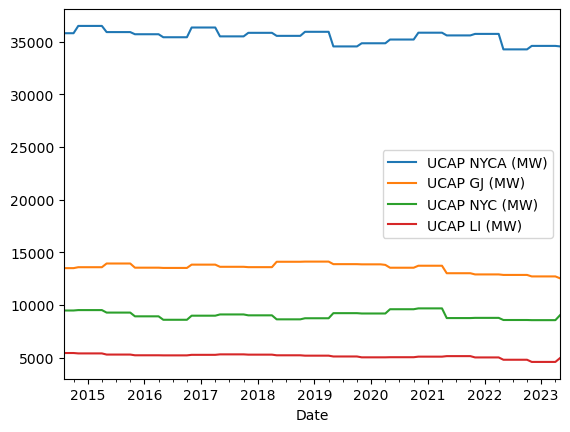

In [7]:
df_gen.set_index('Date',inplace=True)
df_gen.plot()